In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, classification_report
from keybert import KeyBERT
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import torch



In [133]:
df = pd.read_csv("C:\\AIML\\mtsamples.csv")


print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB
None
Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64


In [135]:
# Preview the dataset
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [137]:
# for this classification project , retain only the 'transcription' (text data) and 'medical_specialty' (target label) columns
# there are 33 null values for the medical transcriptions text , Fill them with unknown values 
# Drop rows with missing transcription
df = df.dropna(subset=['transcription'])

# Drop unnecessary columns
df = df[['medical_specialty', 'transcription']]
df.fillna('Unknown', inplace=True)

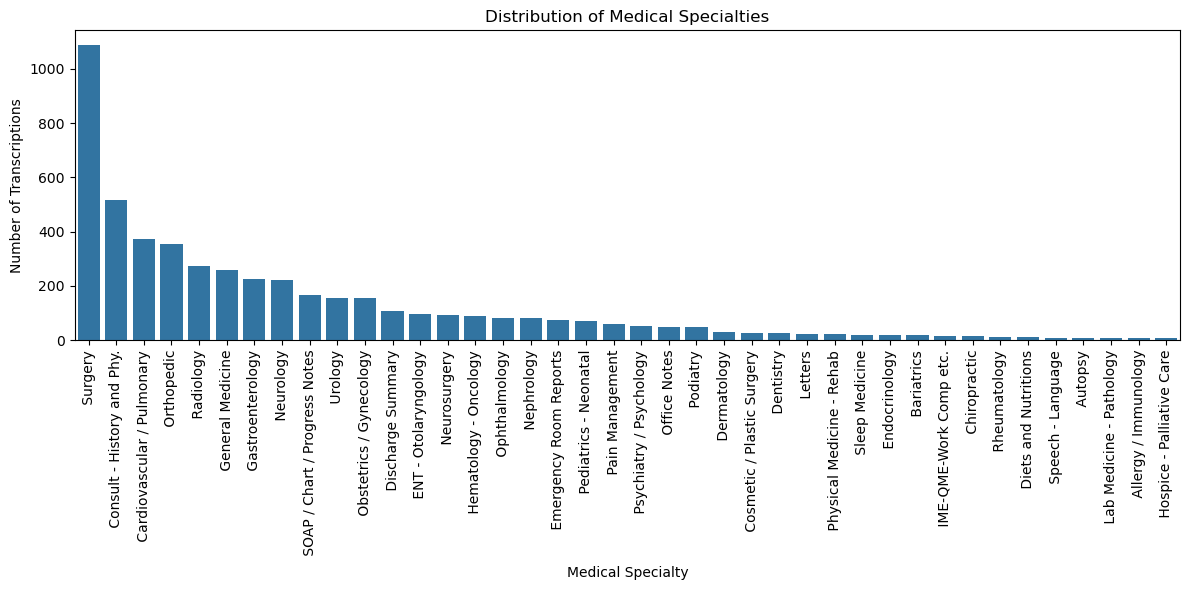

In [139]:
#Bar Plot of Most Common Medical Specialties
specialty_counts = df['medical_specialty'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=specialty_counts.index, y=specialty_counts.values)
plt.title('Distribution of Medical Specialties')
plt.xlabel('Medical Specialty')
plt.ylabel('Number of Transcriptions')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

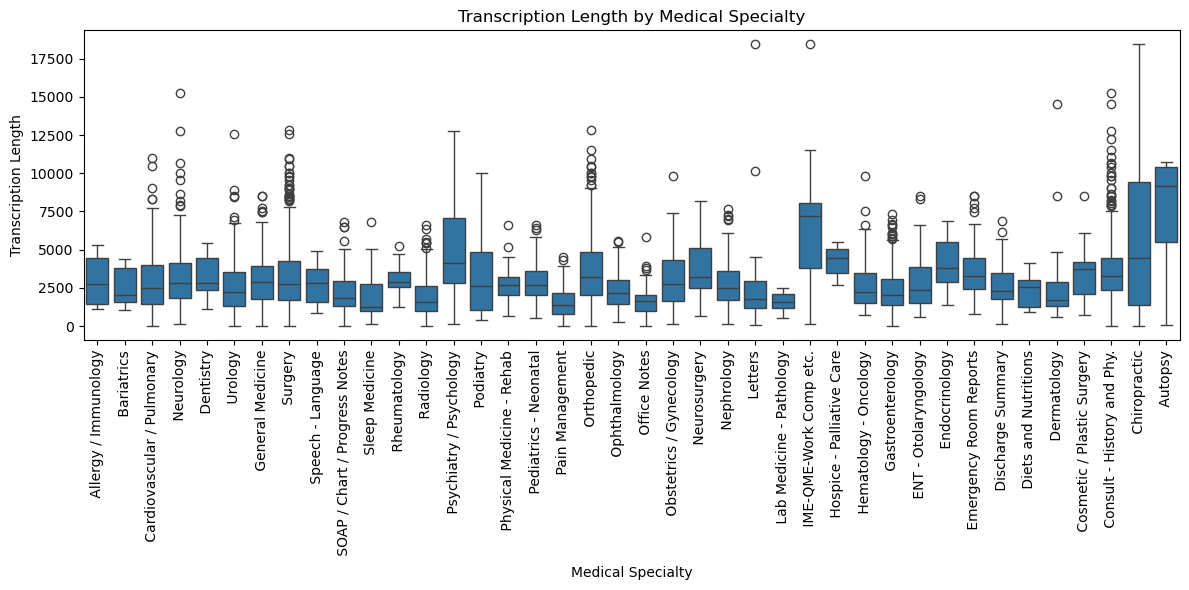

In [141]:
df['transcription_length'] = df['transcription'].apply(len)
plt.figure(figsize=(12, 6))
sns.boxplot(x='medical_specialty', y='transcription_length', data=df)
plt.title('Transcription Length by Medical Specialty')
plt.xlabel('Medical Specialty')
plt.ylabel('Transcription Length')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [143]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Define the stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to C:\Users\H468030/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\H468030/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\H468030/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [145]:
#stop_words = set(stopwords.words('english'))
#lemmatizer = WordNetLemmatizer()
# Function to preprocess text
#def preprocess_text(text):
    #if not isinstance(text, str):
     #return ''
    #tokens = word_tokenize(text.lower())
    #words = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    #return " ".join(words)

In [147]:

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Split into words and filter out stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    
    # Retain only unique words
    unique_words = set(filtered_words)
    
    return ' '.join(unique_words)

In [149]:
df['cleaned_transcription'] = df['transcription'].apply(preprocess_text)

In [29]:
#Use TF-IDF to identify important terms within each medical specialty.
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10)

# Fit and transform the cleaned transcriptions
X_tfidf = vectorizer.fit_transform(df['cleaned_transcription'])

# Get the feature names (terms)
terms = vectorizer.get_feature_names_out()

In [32]:
# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=terms)

# Add the medical specialty column
tfidf_df['medical_specialty'] = df['medical_specialty']

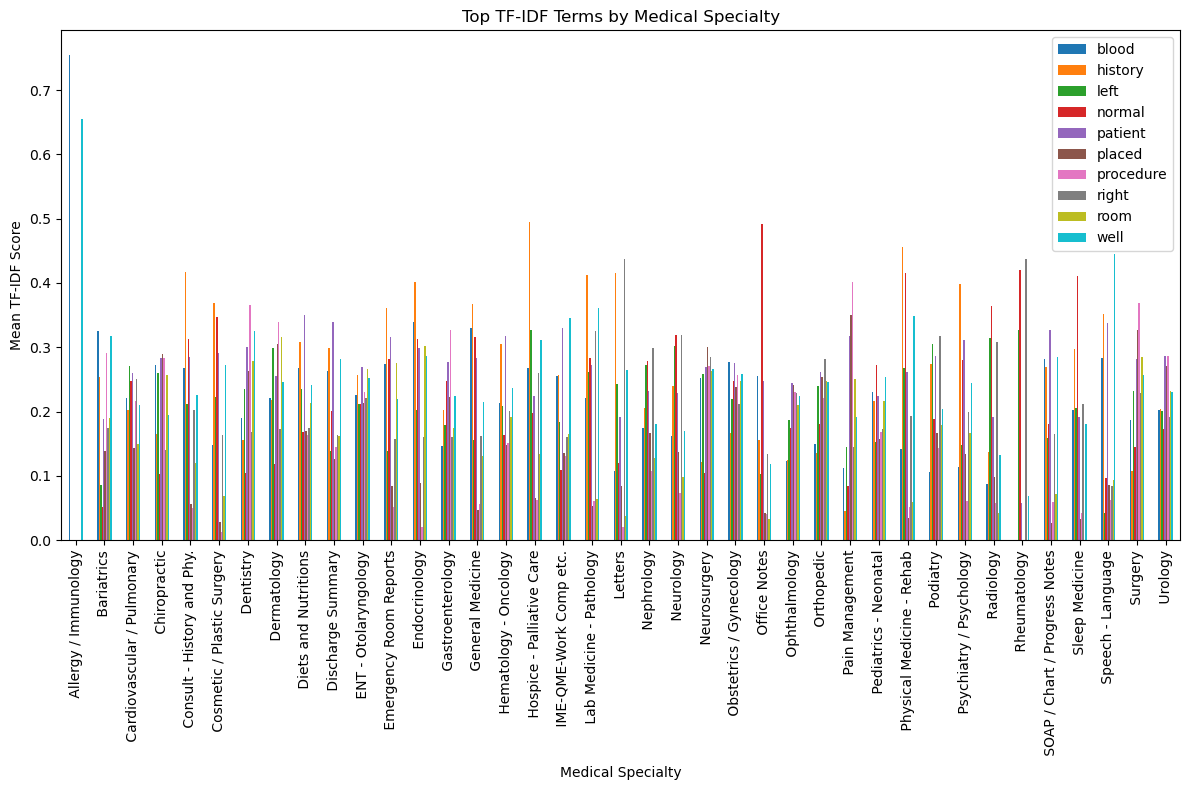

In [34]:
#Plot the most common used words against the medical specialty using the TFIDF Score 

# Group by medical specialty and calculate mean TF-IDF scores
mean_tfidf = tfidf_df.groupby('medical_specialty').mean()

# Plot the top terms for each specialty
mean_tfidf.plot(kind='bar', figsize=(12, 8))
plt.title('Top TF-IDF Terms by Medical Specialty')
plt.ylabel('Mean TF-IDF Score')
plt.xlabel('Medical Specialty')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\H468030/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


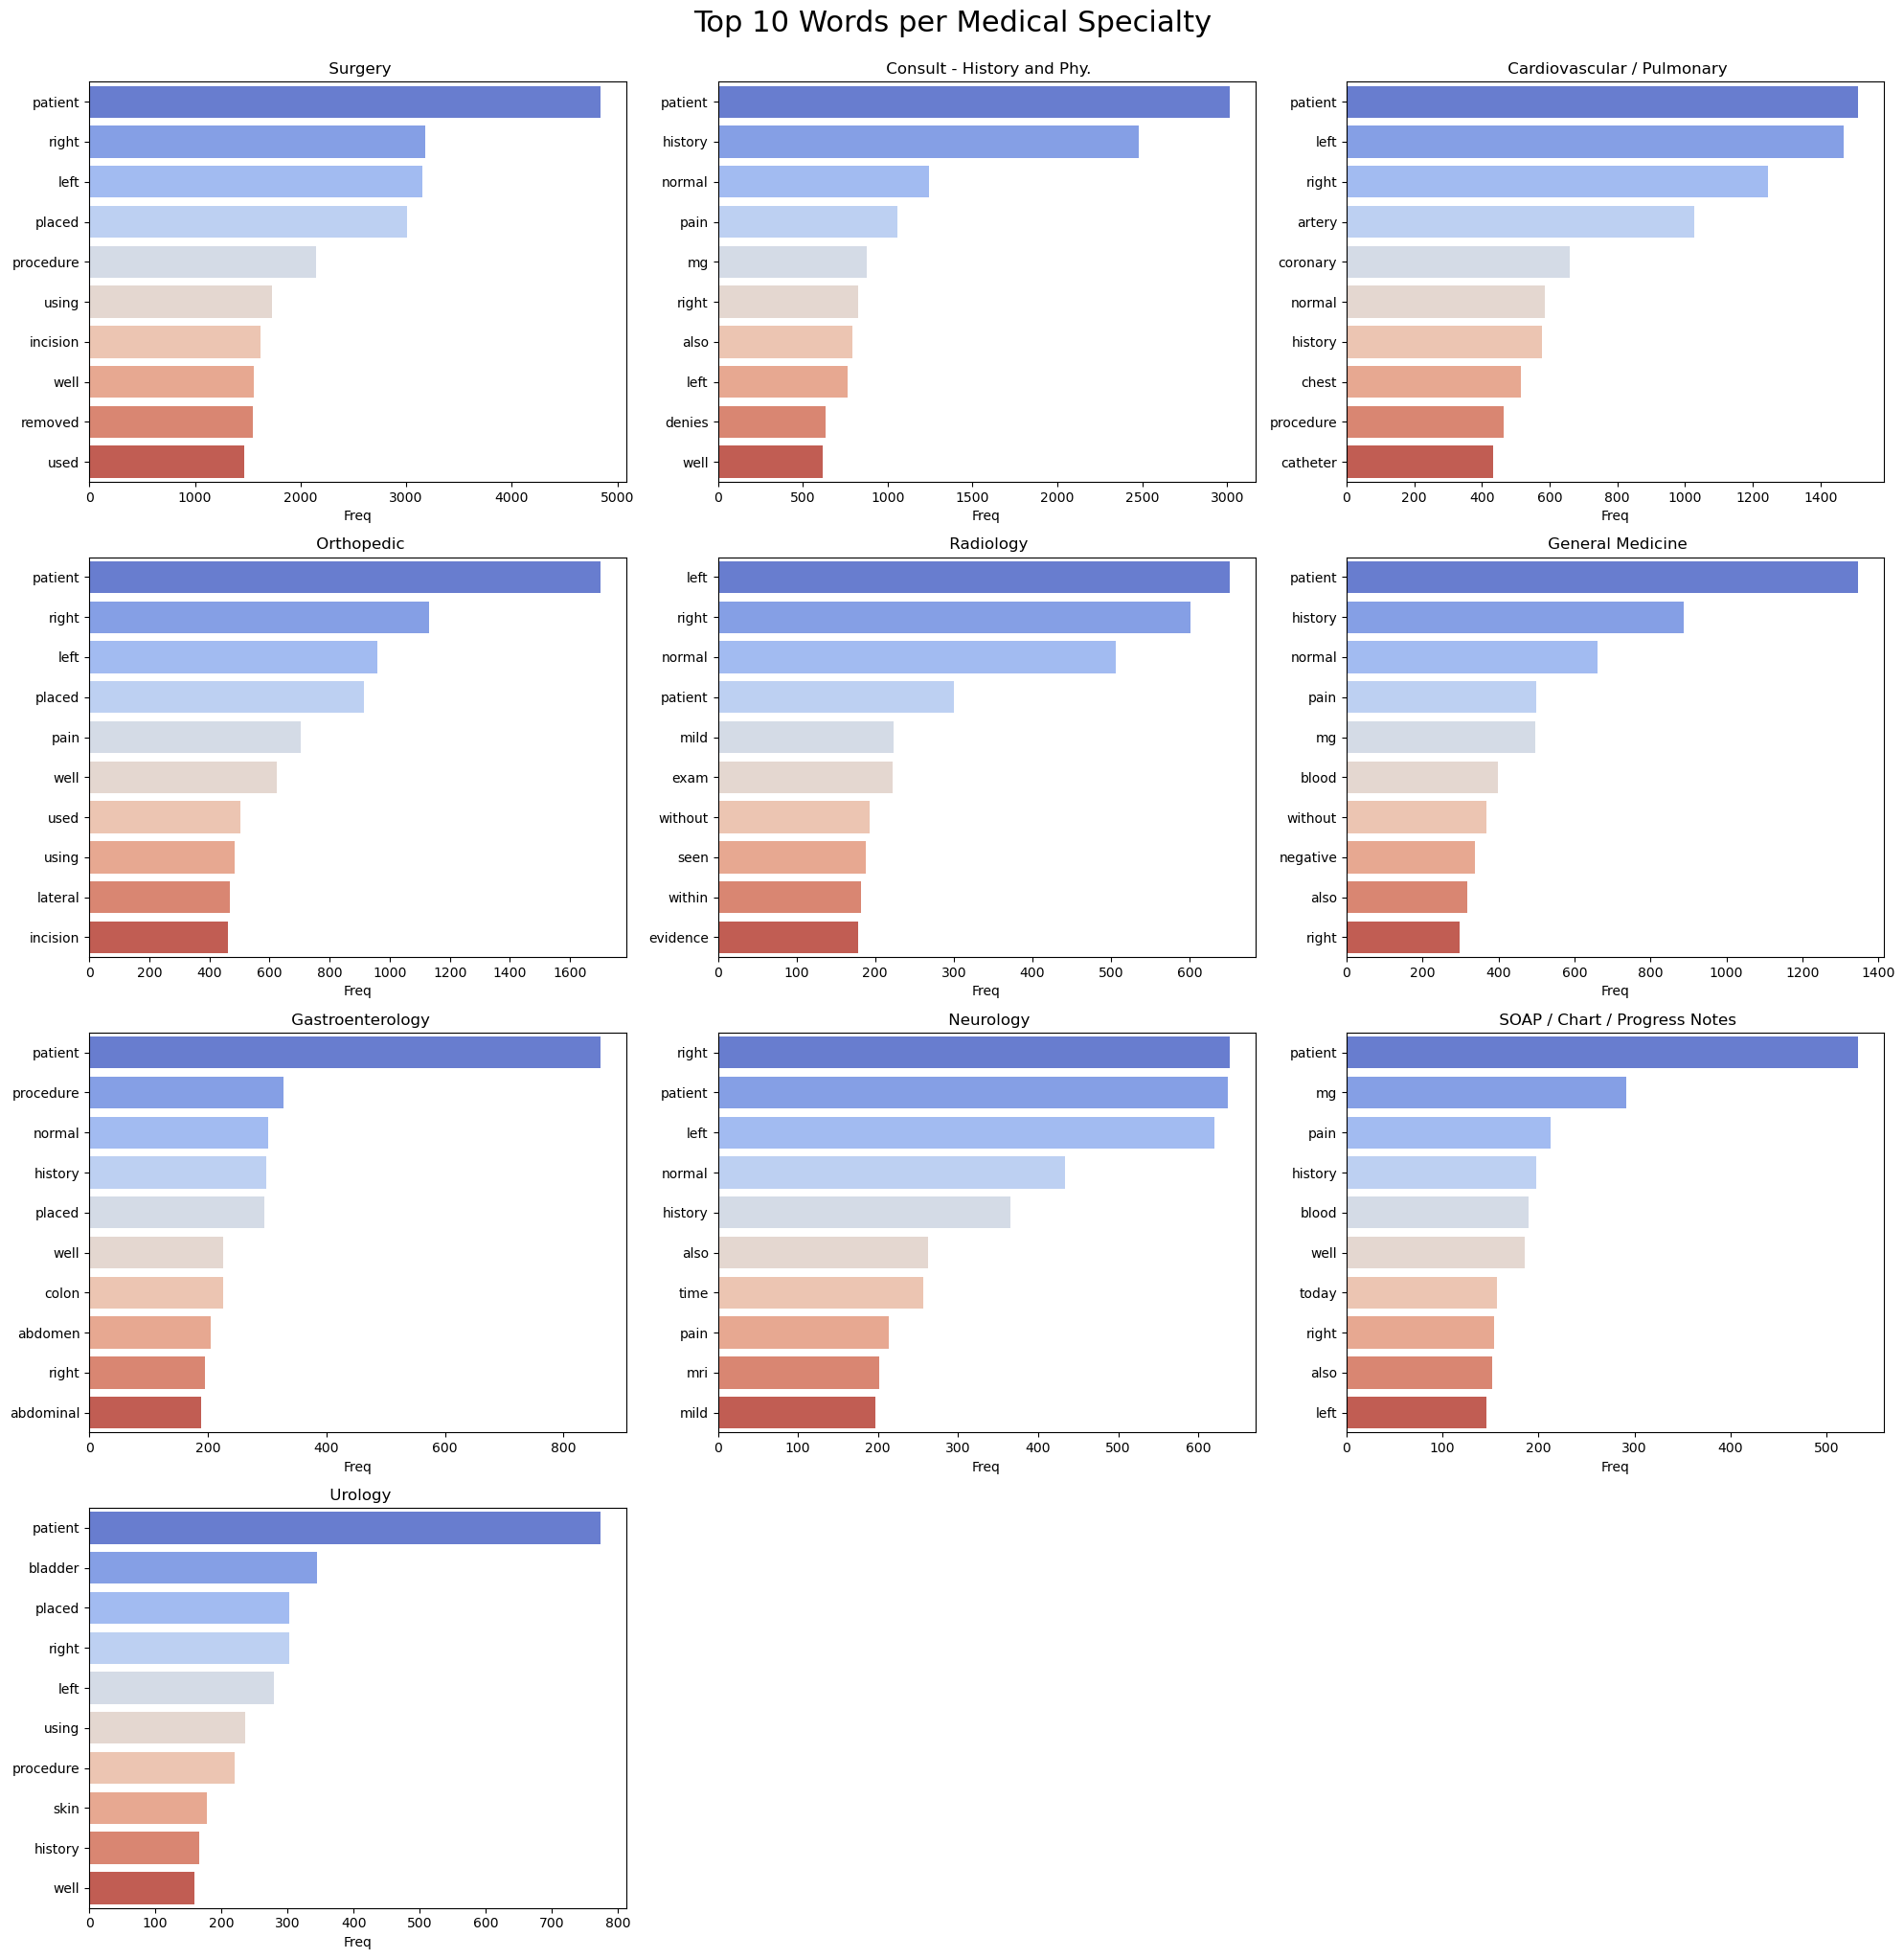

In [36]:

# Setup
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Get top 10 specialties
top_specialties = df['medical_specialty'].value_counts().head(10).index

# Create subplots - 4 rows x 3 columns (will leave 2 blank at end)
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.flatten()  # Flatten for easy indexing

# Plot each specialty
for i, specialty in enumerate(top_specialties):
    subset = df[df['medical_specialty'] == specialty]['transcription'].dropna()

    tokens = " ".join(subset).lower().translate(str.maketrans("", "", string.punctuation)).split()
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]

    word_freq = Counter(filtered_tokens).most_common(10)

    if word_freq:
        words, counts = zip(*word_freq)
        sns.barplot(x=list(counts), y=list(words), ax=axes[i], palette='coolwarm')
        axes[i].set_title(f"{specialty}")
        axes[i].set_xlabel("Freq")
        axes[i].set_ylabel("")
    else:
        axes[i].text(0.5, 0.5, 'No Data', ha='center', va='center')
        axes[i].set_title(f"{specialty}")

# Hide any unused axes
for j in range(len(top_specialties), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Top 10 Words per Medical Specialty", fontsize=22, y=1.02)
plt.show()

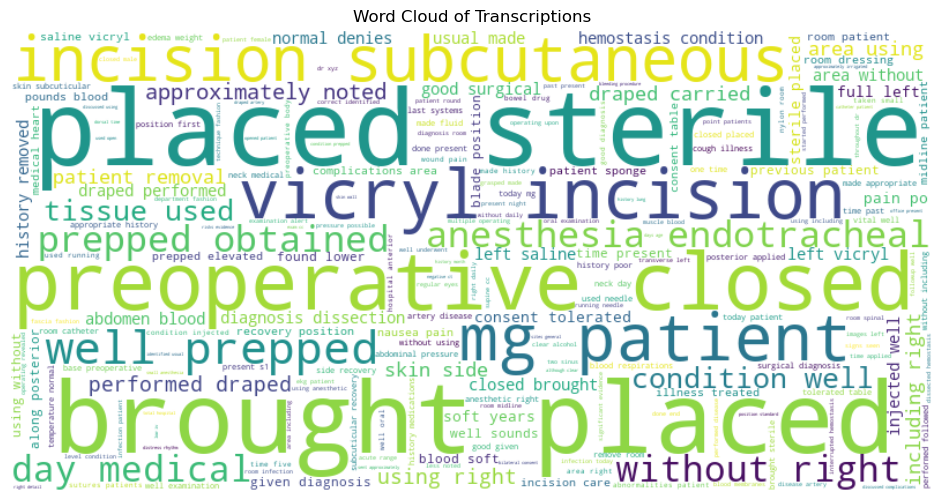

In [38]:
text = " ".join(df['cleaned_transcription'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Transcriptions")
plt.show()

In [39]:
# Initialize model
kw_model = KeyBERT()

In [41]:
def extract_keywords(text, top_n=5):
    """Extract top_n keywords from a given text."""
    return kw_model.extract_keywords(text, top_n=top_n)

In [44]:
df['keywords'] = df['cleaned_transcription'].apply(extract_keywords)

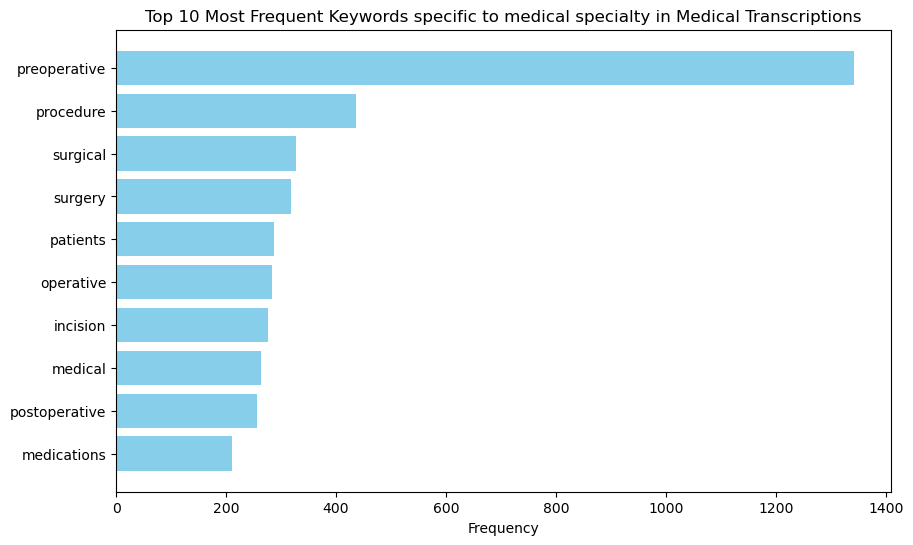

In [45]:
# Flatten the list of keywords
all_keywords = [keyword for sublist in df['keywords'] for keyword, _ in sublist]

# Count occurrences of each keyword
keyword_counts = Counter(all_keywords)

# Get the 10 most common keywords
common_keywords = keyword_counts.most_common(10)

# Separate the keywords and their counts
keywords, counts = zip(*common_keywords)

# Plot the results
plt.figure(figsize=(10, 6))
plt.barh(keywords, counts, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Frequent Keywords specific to medical specialty in Medical Transcriptions')
plt.gca().invert_yaxis()
plt.show()

In [50]:
# Encode the target variable
label_encoder = LabelEncoder()
df['medical_specialty'] = label_encoder.fit_transform(df['medical_specialty'])

# Text Feature Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf_vectorizer.fit_transform(df['cleaned_transcription']).toarray()
y = df['medical_specialty']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Multinomial Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.38
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.43      0.33      0.37        79
           4       0.00      0.00      0.00         2
           5       0.30      0.97      0.46       111
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00        23
          11       0.00      0.00      0.00        32
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00         2
          14       0.33      0.02      0.04        45
          15       0.00      0.00      0.00        44
          16       0.00      0.00      0.00        19
          17

C:\Users\H468030\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\H468030\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\H468030\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [53]:
#Because the accuracy was very less 38% , try sampling 

# Define features and target
X = df['cleaned_transcription']  # or 'transcription' if you prefer full text
y = df['medical_specialty']  # assuming this is the target

from imblearn.over_sampling import RandomOverSampler

# Vectorize text
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

# Oversample
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_vec, y)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

In [61]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier()
}

# Train, predict, and store accuracy
accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

Logistic Regression Accuracy: 0.7931
Multinomial Naive Bayes Accuracy: 0.7798
Support Vector Machine Accuracy: 0.7943
Random Forest Accuracy: 0.7942


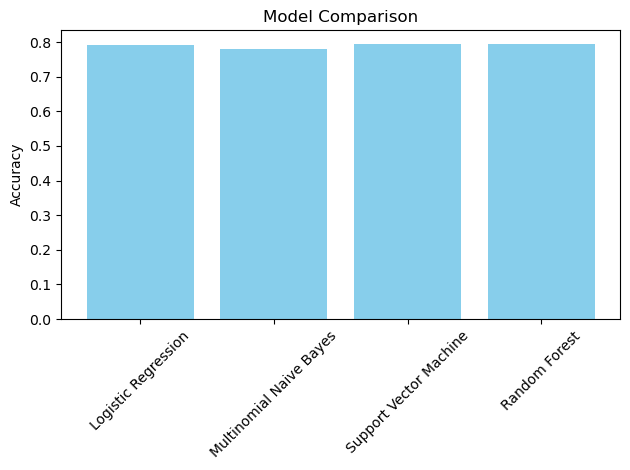

In [62]:

# Plot accuracy
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [69]:
#using SMOTE for resampling 
from imblearn.over_sampling import SMOTE



In [75]:
# Split before applying SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, test_size=0.2, stratify=y, random_state=42)



# Filter rare classes
min_class_size = 100
valid_classes = y_train.value_counts()[y_train.value_counts() >= min_class_size].index
X_train_filtered = X_train[y_train.isin(valid_classes)]
y_train_filtered = y_train[y_train.isin(valid_classes)]

# Apply SMOTE
smote = SMOTE(k_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_filtered.toarray(), y_train_filtered
)



In [81]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier()
}

accuracies = {}
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    
    # If the model needs dense input
    if hasattr(model, 'predict_proba'):
        X_test_input = X_test
    else:
        X_test_input = X_test.toarray()
    
    y_pred = model.predict(X_test_input)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"\n{name} Accuracy: {acc:.4f}")
    


Logistic Regression Accuracy: 0.2133

Multinomial Naive Bayes Accuracy: 0.2797

Support Vector Machine Accuracy: 0.1348

Random Forest Accuracy: 0.1439


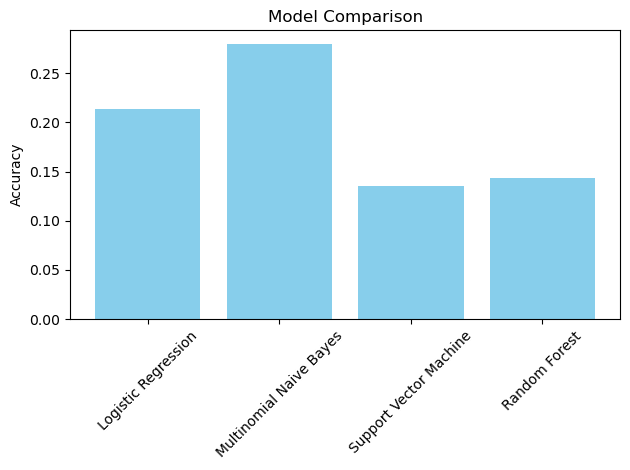

In [82]:
# Plot accuracy
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [89]:
# using the Bio_ClinicalBERT as it is considered ideal for the medical text 
# Install the necessary libraries 


SyntaxError: invalid syntax (317885048.py, line 3)

In [91]:
pip install transformers scikit-learn imbalanced-learn torch

In [93]:
#load the model and the tokenizer
import torch
from transformers import AutoTokenizer, AutoModel

# Load Bio_ClinicalBERT
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()  # Inference mode

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [95]:
#encode text to BERT embeddings
def get_clinicalbert_embeddings(texts, batch_size=16, max_length=128):
    all_embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token
            all_embeddings.append(cls_embeddings)
    return torch.cat(all_embeddings, dim=0).cpu().numpy()

In [ ]:
#filter rare classes for better accuracy: 
texts = df['cleaned_transcription'].tolist()
labels = df['medical_specialty']
min_samples = 10
valid_classes = labels.value_counts()[labels.value_counts() >= min_samples].index
df = df[df['medical_specialty'].isin(valid_classes)]
texts = df['cleaned_transcription'].tolist()
labels = df['medical_specialty']

In [99]:
#generate BERT Embeddings
X = get_clinicalbert_embeddings(texts)
y = labels

In [100]:
#Apply RandomOverSampler (for Balancing the medical specialty)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [101]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

In [109]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracies = {}
acc = accuracy_score(y_test, y_pred)
accuracies['Logistic Regression'] = acc
print(f"\n{'Logistic Regression'} Accuracy: {acc:.4f}")



Logistic Regression Accuracy: 0.7694


In [117]:
 models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
#    'Multinomial Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier()
}

accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)   
   
    y_pred = model.predict(X_test_input)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"\n{name} Accuracy: {acc:.4f}")


Logistic Regression Accuracy: 0.7694

Support Vector Machine Accuracy: 0.6745

Random Forest Accuracy: 0.7730


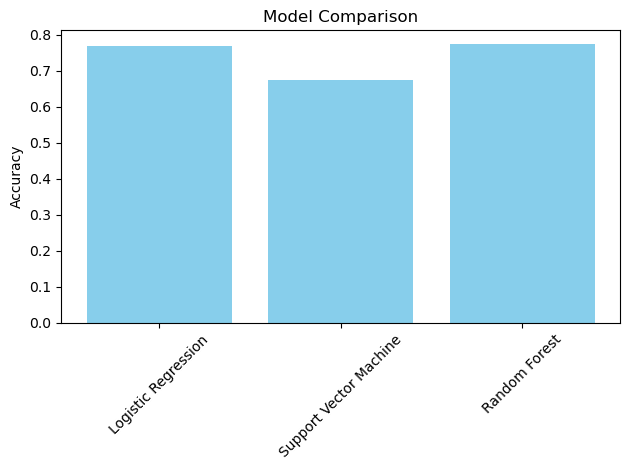

In [119]:
# Plot accuracy
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [153]:
##End-to-End Fine-Tuning with Weighted Loss & Model Saving
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EvalPrediction
)
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
from typing import Dict

# Filter rare classes (optional)
min_samples = 10
df = df[df["medical_specialty"].map(df["medical_specialty"].value_counts()) >= min_samples]

# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["medical_specialty"])
num_labels = len(label_encoder.classes_)

# Train-validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["cleaned_transcription"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Tokenizer
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Dataset class
class ClinicalDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

train_dataset = ClinicalDataset(train_encodings, train_labels)
val_dataset = ClinicalDataset(val_encodings, val_labels)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Custom model class with weighted loss
class WeightedLossBERT(nn.Module):
    def __init__(self, model_name, num_labels, class_weights):
        super().__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.bert.classifier(outputs.pooler_output)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=None,
            attentions=None
        )

# Load custom model
model = WeightedLossBERT(model_name, num_labels, class_weights)

# Metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(p: EvalPrediction) -> Dict:
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./clinicalbert_output",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.985700
1000,2.086100


TrainOutput(global_step=1479, training_loss=2.262840286471539, metrics={'train_runtime': 8343.0696, 'train_samples_per_second': 1.417, 'train_steps_per_second': 0.177, 'total_flos': 0.0, 'train_loss': 2.262840286471539, 'epoch': 3.0})

In [155]:
# Evaluate on validation set after training
eval_results = trainer.evaluate()

# Print metrics
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Validation F1 Score: {eval_results['eval_f1']:.4f}")



Validation Accuracy: 0.3215
Validation F1 Score: 0.2537


In [157]:
#Saving the fine tuned model
save_path = "./fine_tuned_clinicalbert"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

('./fine_tuned_clinicalbert\\tokenizer_config.json',
 './fine_tuned_clinicalbert\\special_tokens_map.json',
 './fine_tuned_clinicalbert\\vocab.txt',
 './fine_tuned_clinicalbert\\added_tokens.json',
 './fine_tuned_clinicalbert\\tokenizer.json')

In [159]:
#Relaoding the model later for Inference
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(save_path)
tokenizer = AutoTokenizer.from_pretrained(save_path)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ./fine_tuned_clinicalbert and are newly initialized: ['albert.embeddings.LayerNorm.bias', 'albert.embeddings.LayerNorm.weight', 'albert.embeddings.position_embeddings.weight', 'albert.embeddings.token_type_embeddings.weight', 'albert.embeddings.word_embeddings.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.LayerNorm.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.LayerNorm.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.dense.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.dense.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight', 'alb

In [161]:
#Example for Inference 
def predict(texts, model, tokenizer):
    model.eval()
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
    return label_encoder.inverse_transform(preds)

# Example usage
text_sample = ["Patient with type 2 diabetes and elevated glucose."]
prediction = predict(text_sample, model, tokenizer)
print("Predicted Specialty:", prediction[0])

Predicted Specialty:  Bariatrics


In [168]:
pip install fastapi uvicorn

In [172]:
import pickle

with open(f"{save_path}/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [178]:
# inference.py
import torch
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load components
model = AutoModelForSequenceClassification.from_pretrained("fine_tuned_clinicalbert")
tokenizer = AutoTokenizer.from_pretrained("fine_tuned_clinicalbert")
with open("fine_tuned_clinicalbert/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

def predict(texts):
    model.eval()
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    return label_encoder.inverse_transform(preds)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at fine_tuned_clinicalbert and are newly initialized: ['albert.embeddings.LayerNorm.bias', 'albert.embeddings.LayerNorm.weight', 'albert.embeddings.position_embeddings.weight', 'albert.embeddings.token_type_embeddings.weight', 'albert.embeddings.word_embeddings.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.LayerNorm.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.LayerNorm.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.dense.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.dense.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight', 'alber

In [180]:
pip install huggingface_hub

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from inference import predict

app = FastAPI()

class InputText(BaseModel):
    text: str

@app.post("/predict")
def classify(input: InputText):
    prediction = predict([input.text])
    return {"predicted_specialty": prediction[0]}